In [30]:
# ========================
# STEP 0: SETUP & IMPORTS
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()
region = session.boto_region_name


In [12]:
# =============================
# STEP 1: LOAD DATASET (ONLINE)
# =============================
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]

df = pd.read_csv(url, names=columns)


          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  392.000000   392.000000  392.000000     392.000000     392.000000   
mean     0.331633     3.301020  122.627551      70.663265      29.145408   
std      0.471401     3.211424   30.860781      12.496092      10.516424   
min      0.000000     0.000000   56.000000      24.000000       7.000000   
25%      0.000000     1.000000   99.000000      62.000000      21.000000   
50%      0.000000     2.000000  119.000000      70.000000      29.000000   
75%      1.000000     5.000000  143.000000      78.000000      37.000000   
max      1.000000    17.000000  198.000000     110.000000      63.000000   

          Insulin         BMI  DiabetesPedigreeFunction         Age  
count  392.000000  392.000000                392.000000  392.000000  
mean   156.056122   33.086224                  0.523046   30.864796  
std    118.841690    7.027659                  0.345488   10.200777  
min     14.000000   18.200000      

[04/09/25 05:15:59] INFO     Using categorical units to plot a list of strings that are all         ]8;id=530706;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=51090;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=569001;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=454432;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

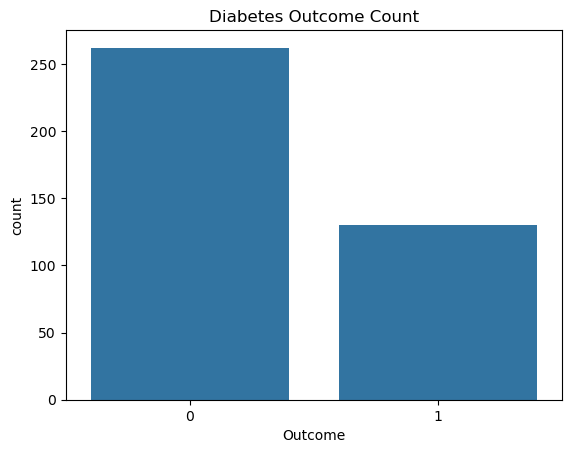

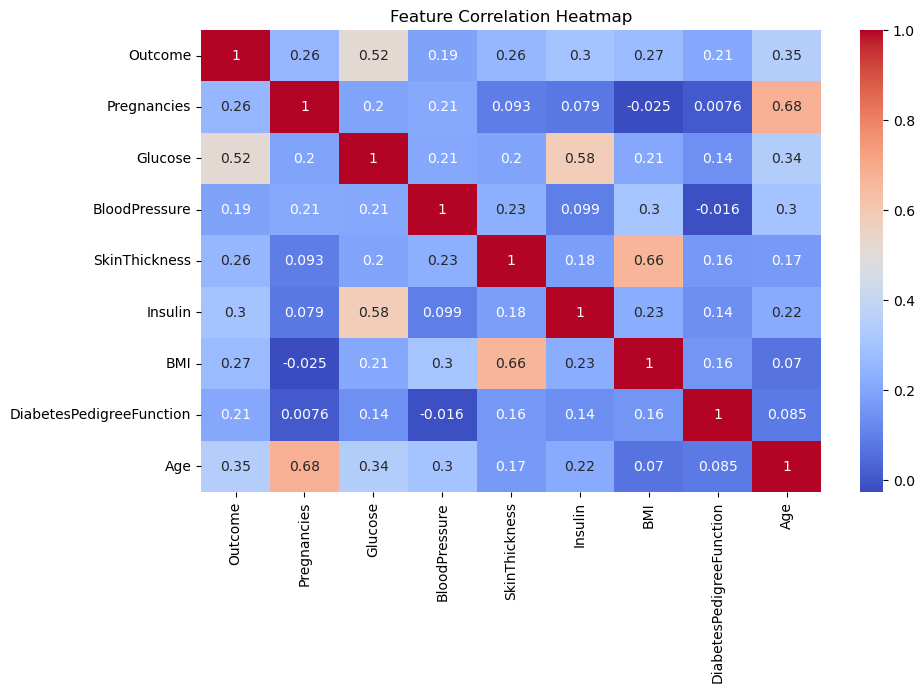

In [31]:
# ========================
# STEP 2: DATA EXPLORATION
# ========================
print(df.describe())
print(df['Outcome'].value_counts())

# Plot distribution of target
sns.countplot(data=df, x="Outcome")
plt.title("Diabetes Outcome Count")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [32]:
# ================================
# STEP 3: CLEANING & SPLIT
# ================================
# Replace zeroes in some columns with NaNs
columns_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[columns_to_fix] = df[columns_to_fix].replace(0, np.nan)
df.dropna(inplace=True)

# Convert labels to int (they may be float due to pandas dtype inference)
df['Outcome'] = df['Outcome'].astype(int)

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save to CSVs without headers/indices
train_df.to_csv("train.csv", index=False, header=False)
test_df.to_csv("test.csv", index=False, header=False)

In [33]:
# Re-load if needed (in case intermediate cells were run out of order)
df = pd.read_csv(url, names=columns)

# Clean and drop invalids
columns_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[columns_to_fix] = df[columns_to_fix].replace(0, np.nan)
df.dropna(inplace=True)

# Ensure correct label format
df['Outcome'] = df['Outcome'].astype(int)

# Reorder columns: label first
columns_order = ['Outcome'] + [col for col in df.columns if col != 'Outcome']
df = df[columns_order]

# Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save without headers or index
train_df.to_csv("train.csv", index=False, header=False)
test_df.to_csv("test.csv", index=False, header=False)

# Sanity check: Make sure labels are 0/1
print("Label check:", train_df.iloc[:, 0].unique())  # Should be [0 1]


Label check: [1 0]


In [34]:
# ========================
# STEP 4: UPLOAD TO S3
# ========================
s3_train = session.upload_data("train.csv", bucket=bucket, key_prefix="diabetes/train")
s3_test = session.upload_data("test.csv", bucket=bucket, key_prefix="diabetes/test")

print("Uploaded to:")
print("Train:", s3_train)
print("Test:", s3_test)


Uploaded to:
Train: s3://sagemaker-us-east-1-439143907755/diabetes/train/train.csv
Test: s3://sagemaker-us-east-1-439143907755/diabetes/test/test.csv


In [35]:
# ========================================
# STEP 5: MODEL TRAINING (XGBoost)
# ========================================
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator

container = sagemaker.image_uris.retrieve("xgboost", region, "1.5-1")

xgb = Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/diabetes/output',
    sagemaker_session=session
)

xgb.set_hyperparameters(
    objective='binary:logistic',
    num_round=100,
    max_depth=5,
    eta=0.3,
    gamma=2,
    min_child_weight=4,
    subsample=0.8
)

train_input = TrainingInput(s3_data=s3_train, content_type="text/csv")

xgb.fit({'train': train_input})


[04/09/25 05:20:54] INFO     Ignoring unnecessary instance type: None.                            ]8;id=381879;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=432710;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=492604;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=390724;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=424552;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=334303;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-04-09-05-20-54-948                                             

2025-04-09 05:20:57 Starting - Starting the training job...
2025-04-09 05:21:12 Starting - Preparing the instances for training...
2025-04-09 05:21:38 Downloading - Downloading input data...
2025-04-09 05:22:23 Downloading - Downloading the training image......
2025-04-09 05:23:25 Training - Training image download completed. Training in progress.
2025-04-09 05:23:25 Uploading - Uploading generated training model/miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-04-09 05:23:19.742 ip-10-0-119-212.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-04-09 05:23:19.764 ip-10-0-119-212.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-04-09:05:23:20:INFO] Imported framework sagemaker_xgboost_container.training
[2025-04-09:

In [36]:
# ========================
# STEP 6: DEPLOY MODEL
# ========================
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m5.large')

[04/09/25 05:25:49] INFO     Creating model with name: sagemaker-xgboost-2025-04-09-05-25-49-794    ]8;id=826885;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=742427;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/09/25 05:25:50] INFO     Creating endpoint-config with name                                     ]8;id=417291;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=593929;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\
                             sagemaker-xgboost-2025-04-09-05-25-49-794                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-04-09-05-25-49-794  ]8;id=133337;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=42090;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

------!

In [38]:
# =====================
# STEP 7: INFERENCE 
# =====================

# Sample test row (excluding label column)
sample = test_df.drop("Outcome", axis=1).iloc[0]

# Convert to CSV string, then to bytes
payload = ','.join(map(str, sample.values)).encode("utf-8")

# Call the endpoint with correct ContentType
response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})

# Output prediction
print("Prediction (0 = No Diabetes, 1 = Diabetes):", response)


Prediction (0 = No Diabetes, 1 = Diabetes): b'0.28827986121177673\n'


In [39]:
# ========================
# STEP 8: CLEAN-UP
# ========================
predictor.delete_endpoint()

[04/09/25 05:29:42] INFO     Deleting endpoint configuration with name:                             ]8;id=564716;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=170265;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4995\4995]8;;\
                             sagemaker-xgboost-2025-04-09-05-25-49-794                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-04-09-05-25-49-794 ]8;id=9676;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=678714;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4985\4985]8;;\